Use Google Colab to run this code.

In [1]:
# connect to drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# for importing .py files

import sys
sys.path.append('drive/My Drive/ML/')

%load_ext autoreload
%autoreload 2

In [0]:
# PLEASE, uncomment and run this code before working

# !pip install sktime
#!cd drive/My\ Drive/ML/data && wget http://www.timeseriesclassification.com/Downloads/Archives/Univariate2018_ts.zip && unzip Univariate2018_ts.zip && rm Univariate2018_ts.zip
# !wget  https://conda.anaconda.org/pytorch/linux-64/faiss-gpu-1.5.0-py36_cuda10.0_1.tar.bz2
# !tar xvjf faiss-gpu-1.5.0-py36_cuda10.0_1.tar.bz2
# !cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
# !pip install mkl

In [0]:
import pandas as pd
import numpy as np
import os
import faiss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils import data
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import accuracy_score

# importing py modules
# check that you have all these files!
from data_process import read_dataset
from clustering import cluster, arrange_clustering
from sampler import UnifLabelSampler

import warnings
warnings.filterwarnings("ignore",category=UserWarning)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class AlexNet(nn.Module):
  def __init__(self, channels, pools, feature_size, num_classes):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv1d(channels[0], channels[1], 7),
        nn.AvgPool1d(pools[0]),
        nn.Sigmoid(),
        nn.Conv1d(channels[1], channels[2], 7),
        nn.AvgPool1d(pools[1]),
        nn.Sigmoid()
    )
    self.features.apply(weights_init)
    self.classifier = nn.Sequential(
        nn.Linear(feature_size, feature_size),
        # nn.ReLU(),
        # nn.Linear(feature_size, feature_size),
        # nn.ReLU()
    )
    self.classifier.apply(weights_init)
    # self.top_layer = nn.Linear(feature_size, num_classes)
    # self.top_layer.apply(weights_init)

  def forward(self, x):
    features_out = self.features(x)
    features_out = torch.flatten(features_out, start_dim=1)
    preds = self.classifier(features_out)
    # if self.top_layer:
    #   preds = self.top_layer(preds)
    # print(preds)
    return features_out, preds, preds

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.1)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.1)
        nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.1)
        nn.init.constant_(m.bias.data, 0.0)

In [0]:
import os
import sys
import pandas as pd
import numpy as np
import faiss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils import data
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import accuracy_score

# importing py modules
from data_process import read_dataset
from clustering import cluster, arrange_clustering
from alexnet import AlexNet
from sampler import UnifLabelSampler

import warnings
warnings.filterwarnings("ignore",category=UserWarning)

def train_test_AlexNet(X_train, X_test, y_train, y_test, log_file, model_file, num_epoch=100, batch_size=32, smooth=[0, 1], visualize_clusters=False):
  # device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  torch.manual_seed(31)
  torch.cuda.manual_seed_all(31)
  np.random.seed(31)

  # prepare file for logging
  orig_stdout = sys.stdout
  f = open(log_file, 'w')
  sys.stdout = f

  # process data
  k = len(np.unique(y_train))
  np_x = np.expand_dims(X_train, axis=1)
  np_y = y_train.astype(dtype=np.int64)
  true_y = y_train.astype(dtype=np.int64)
  print('Data shape train: ', X_train.shape)
  print('Data shape train: ', X_test.shape)
  print('Classes: ', np.unique(y_train, return_counts=True))
  print()

  train_ds = data.TensorDataset(torch.from_numpy(np_x).float(), torch.from_numpy(np_y))
  dataloader = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

  # create model
  # L = time_series length:
  # F = filter size
  # N = num filters
  # P = pool size

  L = X_train.shape[1]
  F = 7
  N = 12
  P = 3
  feature_size = int(((L - F + 1)//P - F + 1)//P * N)

  net = AlexNet(channels=[1, 6, 12],
           pools=[3, 3],
           feature_size=feature_size,
           num_classes=len(np.unique(np_y)+1))
  criterion = CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=10**(-5))
  # net.to(device)

  # fd = int(net.top_layer.weight.size()[1])
  # net.top_layer = None

  feature_average = None
  train_dataset = None
  nmi = 0
  anmi = 0
  diff_norm = 0

  # traing loop
  for epoch in range(num_epoch):
      running_loss = 0.0

      # remove head
      # net.top_layer = None
      # net.classifier = nn.Sequential(*list(net.classifier.children())[:-1])

      # extract features for clustering
      all_features = []

      net.eval()
      with torch.no_grad():
          for i, batch in enumerate(dataloader, 0):
              inputs, _ = batch
              # inputs = inputs.to(device)
              feats, _, _ = net(inputs)
              all_features.append(feats.detach().numpy())
      net.train()

      if feature_average is None:
          feature_average = np.vstack(all_features)
      else:
          prev_feature_average = feature_average
          feature_average = smooth[0] * feature_average + smooth[1] * np.vstack(all_features)

      cluster_loss, ts_lists = cluster(feature_average, k, visualize_clusters=visualize_clusters)

      if epoch % 10==0:
        if epoch != 0:
          prev_train_dataset = train_dataset
          train_dataset = arrange_clustering(ts_lists)

          nmi = normalized_mutual_info_score(prev_train_dataset, train_dataset)
          anmi = adjusted_mutual_info_score(prev_train_dataset, train_dataset)
        else:
          train_dataset = arrange_clustering(ts_lists)

      # sampler
      dict_ts_lists = {label: indices for label, indices in enumerate(ts_lists)}
      sampler = UnifLabelSampler(len(train_dataset), dict_ts_lists)

      # dataset with new pseudolabels
      train_ds = data.TensorDataset(torch.from_numpy(np_x).float(), torch.from_numpy(train_dataset))
      trainloader = data.DataLoader(train_ds, batch_size=batch_size, sampler=sampler)

      # set last fully connected layer
      # mlp = list(net.classifier.children())
      # mlp.append(nn.ReLU(inplace=True))
      # net.classifier = nn.Sequential(*mlp)
      # net.top_layer = nn.Linear(fd, len(ts_lists))
      # net.top_layer.weight.data.normal_(0, 0.1)
      # net.top_layer.bias.data.zero_()
      # print('ok3')

      # regular forward/backward passes

      # create an optimizer for the last fc layer
      # optimizer_tl = torch.optim.SGD(
      #     net.top_layer.parameters(),
      #     lr=0.001,
      #     weight_decay=10**(-5),
      # )

      accs = []
      for i, batch in enumerate(trainloader, 0):
          inputs, labels = batch
          optimizer.zero_grad()
          # inputs = inputs.to(device)
          # labels = labels.to(device)
          feats, outputs, _ = net(inputs)

          loss = criterion(outputs, labels)
          acc = accuracy_score(labels.tolist(), np.argmax(outputs.tolist(), axis=1))
          accs.append(acc)

          # compute gradient and do SGD step
          
          # optimizer_tl.zero_grad()
          loss.backward()
          optimizer.step()
          # optimizer_tl.step()

          running_loss += loss.item()
          if i % 10 == 0:
            print('Epoch [%d, %5d] loss: %.3f, cluster_loss: %.3f, acc: %.3f, nmi: %.3f, Anmi: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10, cluster_loss, np.mean(accs), nmi, anmi))
            running_loss = 0.0

  torch.save(net, model_file)

  # accuracy on train
  feat, preds, preds_sm = net.forward(torch.Tensor(np_x))
  preds_labels = np.argmax(preds_sm.detach().numpy(), axis=1)
  acc_train = accuracy_score(y_train.astype(int), preds_labels)

  # accuracy on test
  np_x_test = np.expand_dims(X_test, axis=1)
  feat, preds, preds_sm = net.forward(torch.Tensor(np_x_test))
  preds_labels = np.argmax(preds_sm.detach().numpy(), axis=1)
  acc_test = accuracy_score(y_test.astype(int), preds_labels)

  if len(np.unique(y_train)) == 2 and acc_train < 0.5:
    acc_train = 1 - acc_train
    acc_test = 1 - acc_test

  print('\nAccuracy train: %.3f, accuracy test: %.3f' % (acc_train, acc_test))

  sys.stdout = orig_stdout
  f.close()

  return acc_train, acc_test

In [0]:
sharp = [
  "TwoPatterns",
  "ChlorineConcentration",
  "wafer",
  "MedicalImages",
  "FaceAll",
  "OSULeaf",
  "Adiac",
  "SwedishLeaf",
  "yoga",
  "Fish",
  "Lightning7",
  "Lightning2",
  "Trace",
  "syntheticcontrol",
  "FacesUCR",
  "CinCECGtorso",
  "MALLAT",
  "Symbols",
  "Coffee",
  "ECG200",
  "FaceFour",
  "OliveOil",
  "GunPoint",
  "Beef",
  "DiatomSizeReduction",
  "CBF",
  "ECGFiveDays",
  "TwoLeadECG",
  "SonyAIBORobotSurface2",
  "Motestrain",
  "ItalyPowerDemand",
  "SonyAIBORobotSurface1",
]

sharp = [i.lower() for i in sharp]

In [0]:
# LOOP over all datasets
skiplist = [
    'AllGestureWiimoteX',
    'AllGestureWiimoteY',
    'AllGestureWiimoteZ',
    'AsphaltObstacles',
    'AsphaltObstaclesCoordinates',
    'AsphaltPavementType',
    'AsphaltPavementTypeCoordinates',
    'AsphaltRegularity',
    'AsphaltRegularityCoordinates',
    'GesturePebbleZ1',
    'GesturePebbleZ2',
    'PickupGestureWiimoteZ',
    'PLAID',
    'ShakeGestureWiimoteZ',
    'MelbournePedestrian',
    'SmoothSubspace',
    "ItalyPowerDemand"
]
res_path = 'drive/My Drive/ML/alexnet_results.csv'

done_models = []
results = pd.DataFrame(columns=['dataset', 'accuracy_train', 'accuracy_test'])
results.to_csv(res_path)

ind = len(done_models)

path_to_data = 'drive/My Drive/ML/Univariate_ts'
for paths, folders, dataset in os.walk(path_to_data):
  for name in dataset:
    path = paths + '/' + name
    if 'TRAIN' in name and not any(model in name for model in skiplist + done_models):
      dataname = name.split('_')[0]
      if dataname.lower() not in sharp:
        continue
      print('.............%s' % dataname)
     
      X_train, y_train = read_dataset(path)
      y_train = y_train.astype(dtype=np.int64)
      enum_labels = {label: i for i, label in enumerate(np.unique(y_train))}
      y_train = np.array([enum_labels[l] for l in y_train]).reshape(y_train.shape)
      print("\t Shape of X_train = %s, y_train = %s" % ( X_train.shape,y_train.shape))
      path_test = path_to_data + '/' + dataname + '/' + dataname + '_TEST.ts'
      X_test, y_test = read_dataset(path_test)
      y_test = y_test.astype(dtype=np.int64)
      y_test = np.array([enum_labels[l] for l in y_test]).reshape(y_test.shape)
      print("\t Shape of X_test = %s, y_test = %s" % (X_test.shape, y_test.shape))
    
      if X_train.shape[0] > 500:
        num_epoch=30
      else:
        num_epoch=100
      log_file = 'drive/My Drive/ML/logs_alexnet/' + dataname + '.txt'
      model_file = 'drive/My Drive/ML/models_alexnet/' + dataname + '.txt'
      acc_train, acc_test = train_test_AlexNet(X_train, X_test, y_train, y_test, log_file, model_file, num_epoch=num_epoch, smooth=[0, 1])
      print('Accuracy: ', acc_train, acc_test)

      results = pd.read_csv(res_path)
      new = pd.DataFrame({'dataset': dataname, 'accuracy_train': acc_train, 'accuracy_test': acc_test}, index =[ind])
      ind += 1
      results = pd.concat([results, new])
      results.to_csv(res_path)

      done_models.append(dataname)


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

def sharpshooter_plot(acc_train, acc_test):
    """
    Comparison of current model with 1-nn Euclidian Distance
    
    acc_train : dict, key is a dataset name, value is an accuracy on train 
    acc_test : dict, key is a dataset name, value is an accuracy on test 
    """
    
    # load 1-nn results
    nn_res = pd.read_csv('drive/My Drive/ML/1nn_results.csv')
    nn_acc_train = {data.lower().replace("_", ""): acc / 100 for data, acc in zip(nn_res['dataset'], nn_res['train_accuracy'])}
    nn_acc_test = {data.lower().replace("_", ""): acc / 100 for data, acc in zip(nn_res['dataset'], nn_res['test_accuracy'])}
    
    for i in range(len(nn_res['dataset'])):
      # if nn_res['dataset'].loc[i] == 'Lighting7':
      #   nn_res['dataset'].loc[i] = 'Lightning7'
      # elif nn_res['dataset'].loc[i] == 'Lighting2':
      #   nn_res['dataset'].loc[i] = 'Lightning2'
      nn_res['dataset'].loc[i] = nn_res['dataset'][i].lower().replace("_", "")

    set_models = set.intersection(set(nn_res['dataset']), set(acc_train.keys()))
    print(set_models)
    # Expected Accuracy Gain
    exp_gain = [acc_train[data.lower().replace("_", "")] / nn_acc_train[data.lower().replace("_", "")] for data in set_models]
    
    # Actual Accuracy Gain
    act_gain = [acc_test[data.lower().replace("_", "")] / nn_acc_test[data.lower().replace("_", "")] for data in set_models]
    
    fig = plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 14})
    plt.fill_between([1, max(exp_gain)], [1, 1], [max(act_gain), max(act_gain)], alpha=0.3)
    plt.fill_between([min(exp_gain), 1], [1, 1], [min(act_gain), min(act_gain)], alpha=0.3)    
    plt.plot(exp_gain, [1] * len(exp_gain)) # line y = 1
    plt.plot([1] * len(act_gain), act_gain) # line x = 1
    plt.scatter(exp_gain, act_gain, c='black')
    plt.text((max(exp_gain) + 1) / 2, (max(act_gain) + 1) / 2, 'TP', fontsize=18)
    plt.text((max(exp_gain) + 1) / 2, (min(act_gain) + 1) / 2, 'FP', fontsize=18)
    plt.text((min(exp_gain) + 1) / 2, (max(act_gain) + 1) / 2, 'FN', fontsize=18)
    plt.text((min(exp_gain) + 1) / 2, (min(act_gain) + 1) / 2, 'TN', fontsize=18)
    plt.title('Texas Sharpshooter Plot')
    plt.xlabel('Expected Accuracy Gain')
    plt.ylabel('Actual Accuracy Gain')
    
    fig.savefig('drive/My Drive/ML/sharpshooter_plot.png')


In [0]:
res_path = 'drive/My Drive/ML/alexnet_results.csv'

results = pd.read_csv(res_path)
acc_train = {d.lower(): a for d, a in zip(results['dataset'], results['accuracy_train'])}
acc_test = {d.lower(): a for d, a in zip(results['dataset'], results['accuracy_test'])}

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


{'oliveoil', 'chlorineconcentration', 'trace', 'facefour', 'ecg200', 'swedishleaf', 'adiac', 'wafer', 'ecgfivedays', 'medicalimages', 'facesucr', 'syntheticcontrol', 'mallat', 'beef', 'twopatterns', 'diatomsizereduction', 'twoleadecg', 'cbf', 'fish', 'symbols', 'cincecgtorso', 'yoga', 'coffee', 'osuleaf', 'faceall'}


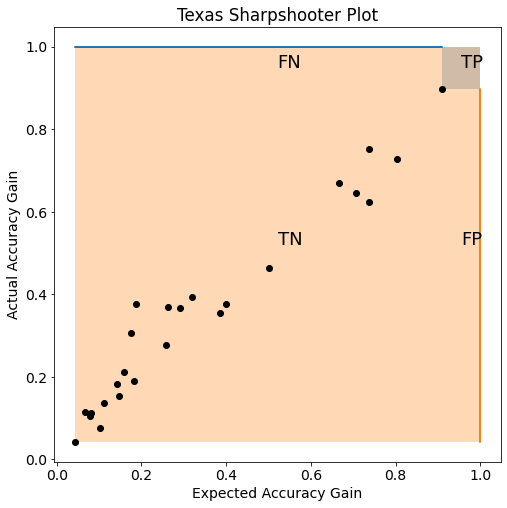

In [51]:
sharpshooter_plot(acc_train, acc_test)